## Ashish Kumar Sinha

### NLP Assignment 3
### MDS201904

In [38]:
import os
from tqdm import tqdm
import re
import fileinput
import collections
import nltk
from nltk import ngrams
import pickle
import csv
import operator
import random
import math
from time import time
import logging
# from numba import jit, cuda
from IPython.display import Image
nltk.download('punkt')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from nltk.stem import WordNetLemmatizer
from gensim.test.utils import datapath
from gensim import utils
import gensim.models
from gensim.utils import lemmatize
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec, KeyedVectors


#import spacy
#from spacy_langdetect import LanguageDetector
#nlp = spacy.load('en')
#nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

! pip install langid
import langid

import gc

! pip install in_place
import in_place

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ashis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preproceesing Steps
The current corpus contains one sentence per line with all the stop words included and all the words in there original form.<br>
To make word vectors and knowledge graph on top of it we need to perform some preprocessing steps

- **Remove Stopwords** - as they do not provide any extra information for the word2vec model and word similarity
- **Lemmatization** - words like “are, is, being” and plurals, etc. are transformed  “be”, signular and so on.
- **Remove Small sentences** sentences of less than 5 tokens(words) as not considered in making word vectors

In [50]:
lemmatizer = WordNetLemmatizer()

In [65]:
class text_generator:
    # a text generator class to generate text iteratively
    def __init__(self,file_path):
        self.file_path = file_path
        
    def __iter__(self):
        for line in open(self.file_path, encoding = 'utf-8'):
            line = remove_stopwords(line)
            lemmatized_out = [lemmatizer.lemmatize(word) for word in line.split(' ')]
            tokens = utils.simple_preprocess(' '.join(lemmatized_out))
            if(len(tokens) < 5): continue
            else:
                yield tokens

In [71]:
text = text_generator('data/preprocessed.txt')

### Computing Word Vectors

In [72]:
start = time()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = Word2Vec(text, size=128, window=5, min_count=50, workers=10, iter=10)
model.save('data/text8.model.bin')
end = time()
print('Execution time in seconds: ' + str(end-start))

2021-04-06 16:59:20,349 : INFO : collecting all words and their counts
2021-04-06 16:59:20,351 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-06 16:59:21,083 : INFO : PROGRESS: at sentence #10000, processed 128996 words, keeping 13550 word types
2021-04-06 16:59:21,795 : INFO : PROGRESS: at sentence #20000, processed 255722 words, keeping 20445 word types
2021-04-06 16:59:22,542 : INFO : PROGRESS: at sentence #30000, processed 385419 words, keeping 25815 word types
2021-04-06 16:59:23,237 : INFO : PROGRESS: at sentence #40000, processed 515717 words, keeping 30342 word types
2021-04-06 16:59:23,974 : INFO : PROGRESS: at sentence #50000, processed 648099 words, keeping 34243 word types
2021-04-06 16:59:24,669 : INFO : PROGRESS: at sentence #60000, processed 777788 words, keeping 37639 word types
2021-04-06 16:59:25,390 : INFO : PROGRESS: at sentence #70000, processed 908655 words, keeping 40840 word types
2021-04-06 16:59:26,080 : INFO : PROGRESS: at 

Execution time in seconds: 8801.554868459702


In [73]:
print('Execution time in Minutes: ' + str((end-start)/60))

Execution time in Minutes: 146.69258114099503


## Extracting Similar Words using Word vectors

In [74]:
def compute_similar_words(model,source_word, topn=5):
    print('\r Computing similar words for the source word - {0}'.format(source_word),end='')
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word,topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)
    return similar_words 

In [75]:
compute_similar_words(model,'fever')

2021-04-06 19:29:25,250 : INFO : precomputing L2-norms of word weight vectors


 Computing similar words for the source word - fever

['fever', 'pyrexia', 'chill', 'febrile', 'paroxysm', 'myalgia']

Computing similar words for **fever** we get
- pyrexia (synomym of fever)
- chill (symptom of fever)
- fibrile (having or showing the symptoms of a fever)
- paroxysm (a sudden attack or spasm)
- myalgia (pain in a muscle or group of muscles)

We get words relating to fever and muscle pain, which are reseonably similar to the word fever

Some more examples - 

In [76]:
compute_similar_words(model,'fatal')

 Computing similar words for the source word - fatal

['fatal', 'severe', 'lifethreatening', 'fulminating', 'fulminant', 'lethal']

In [77]:
compute_similar_words(model,'antigen')

 Computing similar words for the source word - antigen

['antigen', 'autoantigens', 'apc', 'antibody', 'glycoprotein', 'selfantigens']

In [116]:
compute_similar_words(model,'corona')

 Computing similar words for the source word - corona

['corona', 'coronavirus', 'oronavirus', 'borna', 'ebola', 'deadly']

## Building Knowledge Graph using a set of tokens

In [88]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [89]:
keywords = ["russia","hospital","fatal","antigen","symptoms","plasma","sars","fever","steroid","anxiety"]

In [90]:
def compute_similar_words_for_assignment3(model): 
    columns = ['word'+str(i-1) for i in range(1,7)]
    df = pd.DataFrame(data=None,columns=columns)
    for source_word in keywords:
        similar_words = compute_similar_words(model,source_word)
        df.loc[len(df)] = similar_words
        for i in range(1,len(similar_words)):
            sec_similar_words = compute_similar_words(model,similar_words[i])
            df.loc[len(df)] = sec_similar_words
            for i in range(1,len(sec_similar_words)):
                third_similar_words = compute_similar_words(model,sec_similar_words[i])
                df.loc[len(df)] = third_similar_words
   #Save similar words to a file. This file will be used to build the graph
    df.to_csv('data/similar_words_assignment3.csv')

In [91]:
compute_similar_words_for_assignment3(model)

 Computing similar words for the source word - ptsdhoriaecllgy

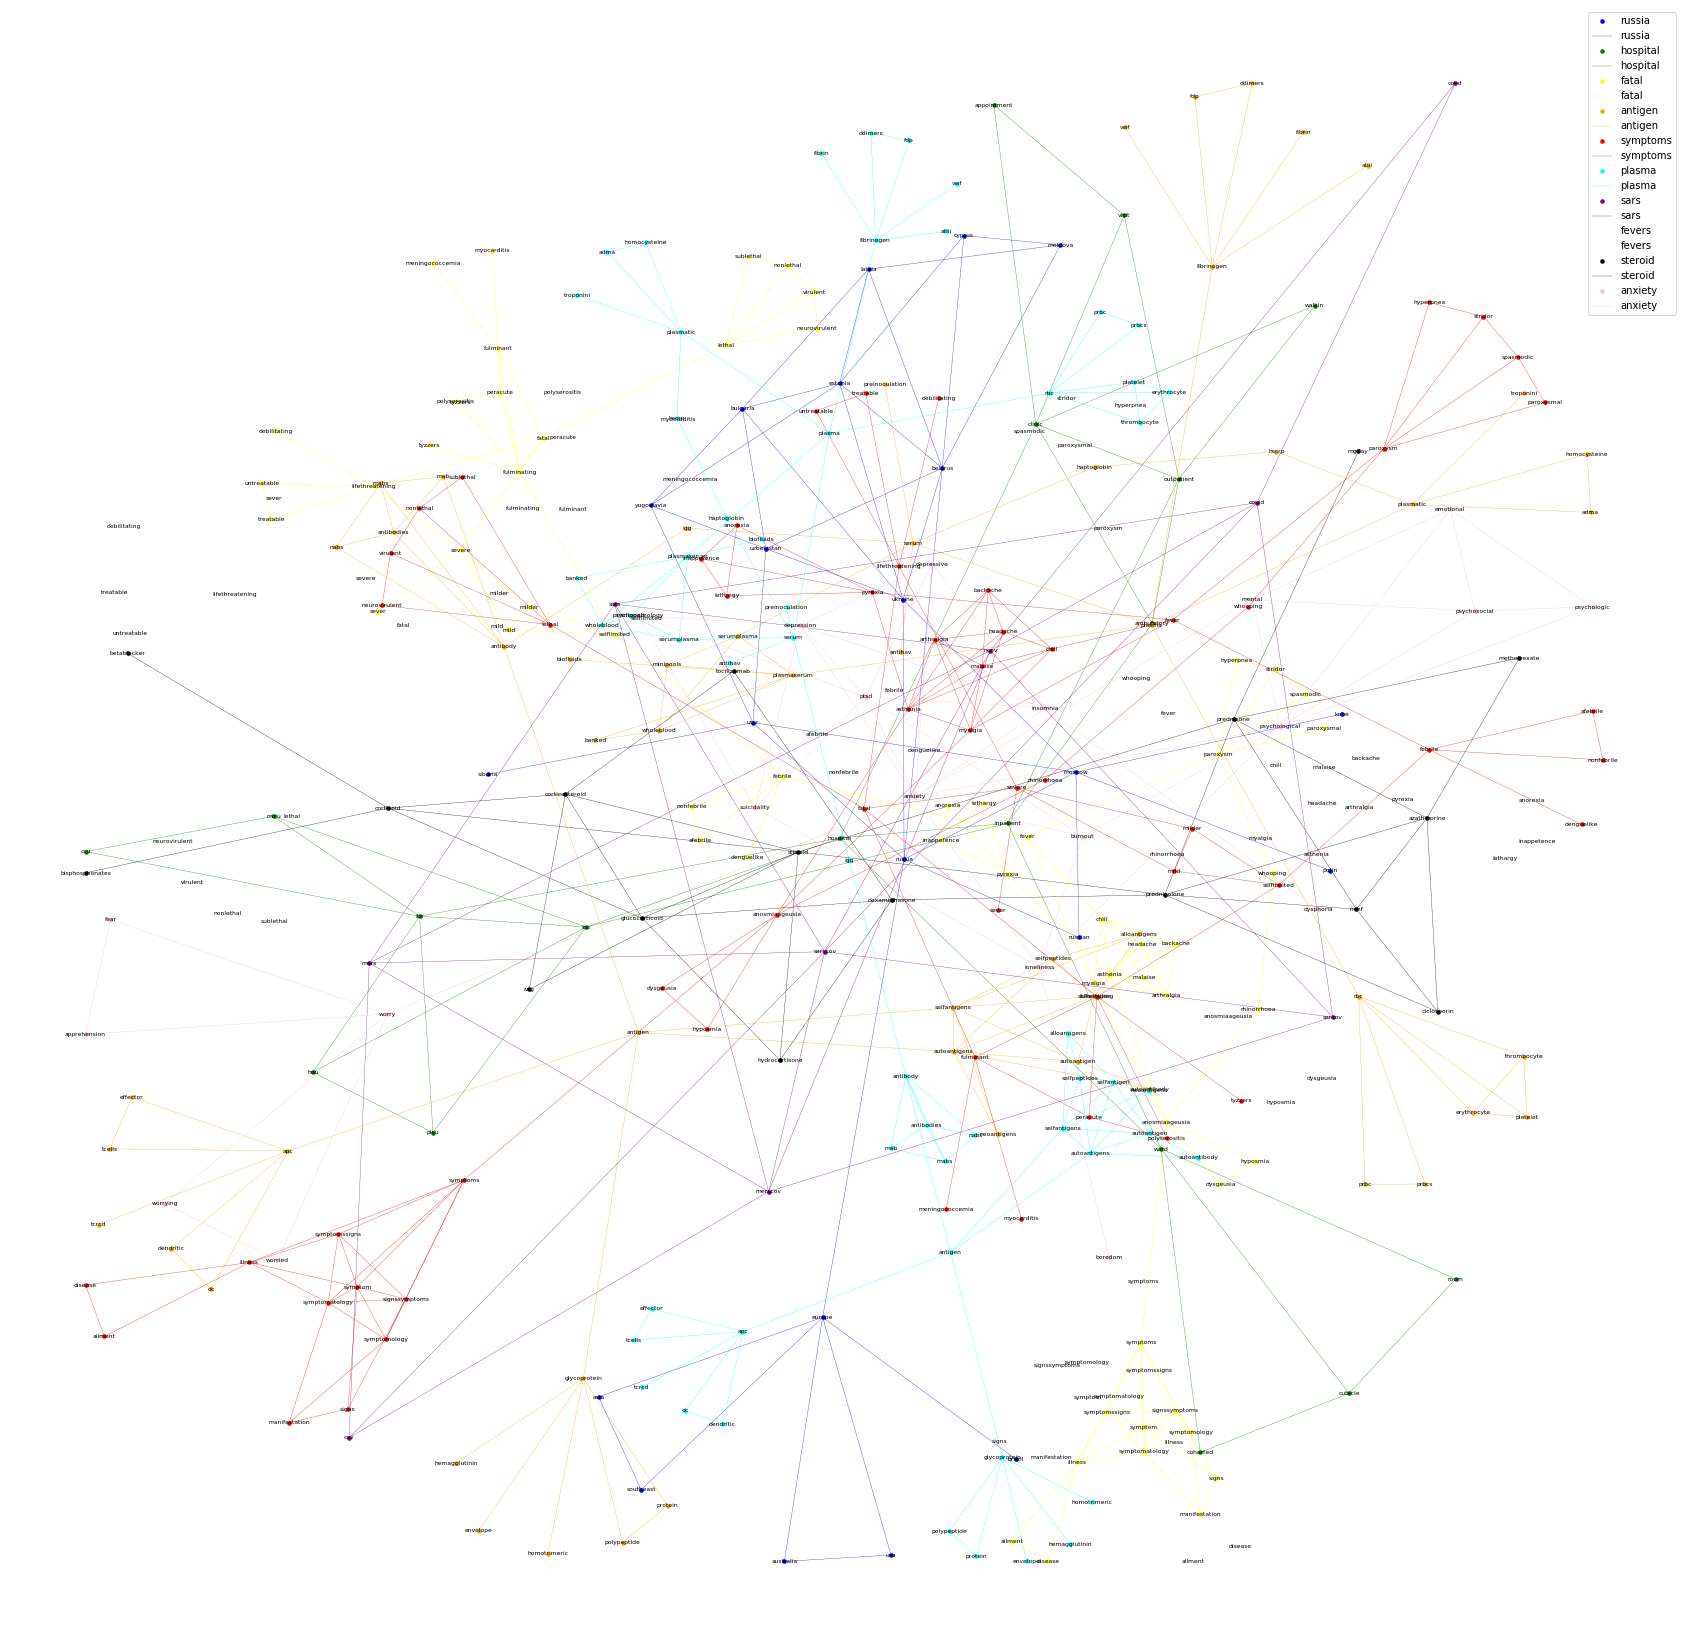

In [93]:
words = pd.read_csv('data/similar_words_assignment3.csv')
g = nx.cubical_graph()

#Construct the graph
#for every source word(node), add edges - connected through similarity
#As there two levels of similar words, we need to repeat the same to construct the graph
for i, row in words.iterrows():
    for j in range(1,len(row)):
        g.add_node(row[j])
    for j in range(1,len(row)):
        g.add_edge(row[1], row[j])    
      
G = nx.petersen_graph()
plt.subplot()
options1 = {
    'node_color': 'blue',
    'node_size': 20,
    'edge_color': 'blue',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}
options2 = {
    'node_color': 'green',
    'node_size': 20,
    'edge_color': 'green',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}
options3 = {
    'node_color': 'yellow',
    'node_size': 20,
    'edge_color': 'yellow',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}
options4 = {
    'node_color': 'orange',
    'node_size': 20,
    'edge_color': 'orange',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}
options5 = {
    'node_color': 'red',
    'node_size': 20,
    'edge_color': 'red',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}
options6 = {
    'node_color': 'cyan',
    'node_size': 20,
    'edge_color': 'cyan',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}
options7 = {
    'node_color': 'purple',
    'node_size': 20,
    'edge_color': 'purple',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}
options8 = {
    'node_color': 'white',
    'node_size': 20,
    'edge_color': 'white',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}
options9 = {
    'node_color': 'black',
    'node_size': 20,
    'edge_color': 'black',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}
options10 = {
    'node_color': 'pink',
    'node_size': 20,
    'edge_color': 'pink',
    'linewidths': 0.1,
    'width': 0.3,
    'font_size':6,
}

fedges = filter(lambda x: g.degree()[x[0]] > 5 and g.degree()[x[1]] > 5, g.edges())
f = nx.Graph()                                                                                                                                     
f.add_edges_from(fedges)

#This is to show how well the keyword is connected with the other words in the corpus  
#change the keyword to obtain a different graph
plt.rcParams['figure.figsize'] = [30, 30]


subgraph1 = nx.node_connected_component(f,'russia')
subgraph2 = nx.node_connected_component(f,'hospital')
subgraph3 = nx.node_connected_component(f,'fatal')
subgraph4 = nx.node_connected_component(f,'antigen')
subgraph5 = nx.node_connected_component(f,'symptoms')
subgraph6 = nx.node_connected_component(f,'plasma')
subgraph7 = nx.node_connected_component(f,'sars')
subgraph8 = nx.node_connected_component(f,'fever')
subgraph9 = nx.node_connected_component(f,'steroid')
subgraph10 = nx.node_connected_component(f,'anxiety')
print()
nx.draw(g.subgraph(subgraph1), with_labels=True, **options1,label = 'russia')
nx.draw(g.subgraph(subgraph2), with_labels=True, **options2, label = 'hospital')
nx.draw(g.subgraph(subgraph3), with_labels=True, **options3, label = 'fatal')
nx.draw(g.subgraph(subgraph4), with_labels=True, **options4, label = 'antigen')
nx.draw(g.subgraph(subgraph5), with_labels=True, **options5, label = 'symptoms')
nx.draw(g.subgraph(subgraph6), with_labels=True, **options6, label = 'plasma')
nx.draw(g.subgraph(subgraph7), with_labels=True, **options7, label = 'sars')
nx.draw(g.subgraph(subgraph8), with_labels=True, **options8, label = 'fevers')
nx.draw(g.subgraph(subgraph9), with_labels=True, **options9, label = 'steroid')
nx.draw(g.subgraph(subgraph10), with_labels=True, **options10, label = 'anxiety')
#nx.draw(g.subgraph(subgraph), with_labels=True, **options)
#nx.draw(g,with_labels = True,**options)
plt.savefig("data/nodes.pdf")
plt.legend()
plt.show()